In [699]:
import pickle
from datetime import datetime, timedelta
import json
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA

from tslearn.metrics import cdist_dtw
from tslearn.clustering import TimeSeriesKMeans

from manage import jsonAttempts2data, jsonExercises2data
from code2aes import Code2Aes
from aes2vec import learnModel, inferVectors, read_corpus, data2cor


# Importation of data

In [700]:
# Import the attemps' embedding and data
with open("Datasets/Embedding/embedding_dublin.json", "r") as f:
    embedding_data = json.load(f)

with open("Datasets/Embedding/embedding_correction_dublin.json", "r") as f:
    embedding_data_correction = json.load(f)

with open("Datasets/Raw/DBExercises.json", "r") as f:
    DBExercises = json.load(f)

chemin = "Datasets/Raw/Dublin_42487.json"
with open(chemin, 'r') as fichier:
    dublin_data = json.load(fichier)

In [701]:
# Dictionary that maps the encoded exercise to its real name
exercice_name_dict = {}
list_exo = list(DBExercises.values())
for exo in list_exo:
    # key : encoded name, value : real name of exercise
    exercice_name_dict[exo["exo_name"]] = exo["funcname"] 
list_exo = list(set(exercice_name_dict.values()))

In [702]:
# We take a percentage of the total data
percentage = 0.1
n = int(len(dublin_data) * percentage)
random_index = random.sample(range(len(dublin_data)), n)
dublin_data_sampled = [dublin_data[i] for i in random_index]
embedding_data_sampled = [embedding_data[i] for i in random_index]

In [703]:
print(f"We've got {len(embedding_data_sampled)} attempts")

We've got 4248 attempts


In [704]:
# Count the number of attempts per exercise
repartition_exercise = {}
for attempts in dublin_data_sampled:
    if attempts["exercise_name"] not in repartition_exercise :
       repartition_exercise[attempts["exercise_name"]] = 1
    else:
        repartition_exercise[attempts["exercise_name"]] += 1

In [705]:
# Delete exercises with fewer than 2 attempts (not enough data for clustering)
under_2_attempts = []
for exercise in repartition_exercise:
    if repartition_exercise[exercise] <= 2:
        under_2_attempts.append(exercise)

for i, attempts in enumerate(dublin_data_sampled):
    if attempts["exercise_name"] in under_2_attempts:
        dublin_data_sampled.pop(i)
        embedding_data_sampled.pop(i)

In [706]:
# Create a list with the names of all exercises
all_exercise = list(DBExercises.keys())

In [707]:
# Delete exercises with fewer than 2 attempts
for exercise in all_exercise:
    if exercise in under_2_attempts:
        del DBExercises[exercise]

# Construction of trajectory

In [708]:
def trajectory_construction_embedding(data, embedding_data, encoded = False, encoder_dictionnary = exercice_name_dict):
    """ 
    Create a dictionary containing all trajectories for each exercise.
    The other dictionary has the same structure, but instead of embeddings, it contains the timestamps of the attempts

    - data: A dictionary containing all attempts and their characteristics.
    - embedding_data: A list of embeddings for each attempt, in the same order as in the data.

    """
    
    # Initialisation of the dictionnaries
    trajec_emb = {}
    trajec_emb_date = {}
    # For every attemp,
    for i, attemps in enumerate(data):
        # Check if the exercise name is encoded in our data
        if encoded:
            exo_encoded = attemps["exercise_name"]
            exercise = exercice_name_dict[exo_encoded]
        else:
            exercise = attemps["exercise_name"]
        student = attemps["user"]
        date = attemps["date"]
        if exercise not in trajec_emb:
            trajec_emb[exercise] = {}
            trajec_emb_date[exercise] = {}
        if student not in trajec_emb[exercise]:
            trajec_emb[exercise][student] = []
            trajec_emb_date[exercise][student] = []
        # Creat the trajectory
        trajec_emb[exercise][student].append(embedding_data[i])
        trajec_emb_date[exercise][student].append(date)
    return trajec_emb, trajec_emb_date

In [709]:
def diff_date_(trajec_date):
    """
    A dictionary with the same structure as our data trajectories.
    It contains the time delta between the attempts in the trajectories and a reference date.

    - trajec_emb_date: A dictionary containing the timestamps of the attempts.

    """
    
    # Choose a random reference date. The only condition is that it must be earlier than every other timestamp.
    reference_date = pd.to_datetime("2018-01-01")
    # Initialisation of the dictionnary
    diff_dates = {}
    for exo in trajec_date:
        if exo not in diff_dates:
            diff_dates[exo] = {}
        for student in trajec_date[exo]:
            list_date = trajec_date[exo][student]
            list_diff_date = []
            # Calcule the timedelta between the reference date and the timestamp of the attemp
            for date in list_date:
                date = pd.to_datetime(date)
                diff_date = date - reference_date
                list_diff_date.append(diff_date)
            diff_dates[exo][student] = list_diff_date
    return diff_dates

In [710]:
def repartition_date_(diff_date):
    """
    Creat a dictionary that, for each exercise, lists all the adjusted timestamps for that exercise. 
      To calculate these adjusted timestamps, we subtract a random date from the attempt timestamps to ensure positive values, 
      then convert the results to days.
    - diff_date: A dictionary that provides the timestamps of every attempt for each trajectory.
    
    """
    # Initialisation of the dictionnary
    repartition_date = {}
    for exo in diff_date:
        repartition_date_list = []
        for list_date in diff_date[exo].values():
            repartition_date_list += list_date
        repartition_date[exo] = repartition_date_list
    return repartition_date

In [711]:
def find_closest_trajectory(date, list_date, trajec):
    """
    - date: The target date for which we want to find the closest date to add the corresponding trajectory.
    - list_date: A list of dates for all trajectories.
    - trajec: A list of all trajectories.
    - return: The closest timestamp to the specified date.
    """
    closest_date = None
    closest_trajectory = None
    min_timedelta = timedelta.max
    date = date.total_seconds() / (24 * 3600)
    
    for i, d in enumerate(list_date):
        d = d.total_seconds() / (24 * 3600)
        delta = d - date
        delta = pd.to_timedelta(delta, unit='D')
        if delta >= timedelta(0) and delta < min_timedelta:
            min_timedelta = delta
            closest_date = d
            closest_trajectory = trajec[i]
    # When there is no more trajectory older than date
    if type(closest_trajectory) == type(None):
        closest_trajectory = trajec[-1]
    return closest_trajectory

In [712]:
def padd_trajectories(diff_date, repartition_date, trajec):
    """
    Pad the trajectories to prepare them for input into a clustering algorithm
    
    - diff_date: A dictionary that provides the timestamps of every attempt for each trajectory.
    - repartition_date: A dictionary that, for each exercise, lists all the adjusted timestamps for that exercise. 
      To calculate these adjusted timestamps, we subtract a random date from the attempt timestamps to ensure positive values, 
      then convert the results to days.
    - trajec : A dictionary containing all trajectories, organized by exercise.
    - Return : dictionnary of padded trajectory

    """

    # Initialisation of the dictionnary
    padded_trajec = {}

    for exo in diff_date:
        list_repartition_date = repartition_date[exo]
        padded_trajec[exo] = {}

        for student in diff_date[exo]:
            list_date = diff_date[exo][student]
            list_trajec = trajec[exo][student]
            list_padded = []
            # k-th attemps of the trajectory
            k = 0
            for rep_date in list_repartition_date:
                if k < len(list_date) and rep_date >= list_date[k]: #.total_seconds() / (24 * 3600):
                    list_padded.append(list_trajec[k])
                    k += 1
                else:
                    # closest_trajectory depends on the type of data in the trajectory:
                    # - If the trajectory contains embeddings, closest_trajectory is an embedding.
                    # - If it involves similarity, closest_trajectory is a similarity measure.
                    closest_trajectory = find_closest_trajectory(rep_date, list_date, list_trajec)
                    list_padded.append(closest_trajectory)

            padded_trajec[exo][student] = list_padded
    return padded_trajec

# Clustering on embedding

In [713]:
def calculate_silhouette_scores_matrice(data):
    """
    - data: The input data for clustering, consisting of all trajectories.
    - Return: The optimal number of clusters that maximizes the silhouette score.
    """
    
    # Compute the DTW distance matrix once
    dists = cdist_dtw(data)
    
    silhouette_scores = []
    max_clus = len(data) - 1
    clus_ = min(max_clus, 12)
    for n_clusters in tqdm(range(2, clus_)):
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=0)
        labels = model.fit_predict(data)
        
        # Use the DTW distance matrix with silhouette_score
        silhouette_avg = silhouette_score(dists, labels, metric="precomputed")
        silhouette_scores.append(silhouette_avg)
        
    if silhouette_scores == []:
        k = "empty"
    else:
        # we add a + 2 since we have at least k = 2
        k = np.argmax(silhouette_scores) + 2
        return k


In [714]:
def get_labels(trajec):
    """
    Use TimeSeriesKMeans clustering with trajectories as input to obtain corresponding labels
    labels_: A dictionary where the keys are exercises and the values are the trajectories for each exercise
    Return : Dictionnary where the keys are exercises and the values are an array of labels for each trajectory

    """
    # Stock the labels data here
    labels_ = {}
    for exo in tqdm(trajec):
        data_exo = np.array(list(trajec[exo].values()))
        # calculate_silhouette_scores_matrice use silouhette score with pre-computed matrice distance
        optimal_n_clusters =  calculate_silhouette_scores_matrice(data_exo)
        # With too few trajectories, it's impossible to determine an optimal number of clusters
        if optimal_n_clusters is not None and data_exo.shape[0] >= optimal_n_clusters:
            model_emb = TimeSeriesKMeans(n_clusters=optimal_n_clusters, metric="dtw", max_iter=10)
            labels = model_emb.fit_predict(data_exo)
            labels_[exo] = labels
    return labels_

In [715]:
def compute_cluster_emb(data, embedding_data):
    trajec_emb, trajec_emb_date = trajectory_construction_embedding(data, embedding_data)
    diff_date = diff_date_(trajec_emb_date)
    repartition_date = repartition_date_(diff_date)
    padded_trajectory = padd_trajectories(diff_date, repartition_date, trajec_emb)
    labels_emb = get_labels(padded_trajectory)
    return labels_emb

In [716]:
padded_trajectory = compute_cluster_emb_test(dublin_data_sampled, embedding_data_sampled)

In [743]:
label_compute = True # Put at True if you want to compute the labels


if label_compute:
    start_time = time.time()
    labels_emb = compute_cluster_emb(dublin_data_sampled, embedding_data_sampled)
    with open(f'Datasets/labels/labels_emb_dublin_{percentage}.pkl', 'wb') as f:
        pickle.dump(labels_emb, f)
    end_time = time.time()
    time_emb = end_time - start_time
else:
    # Open labels that already exist
    with open(f'Datasets/labels/labels_emb_dublin_{percentage}.pkl', 'rb') as f:
        labels_emb = pickle.load(f)

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [744]:
def plot_trajectory(data_visualisation, labels, max_attemps = 100):
    """
    Plot the trajectory of attemps, exercise by exercise
    
    - data_visualisation : list of dictionnary that contain embbeding, correction, date, student id and attemps
    - labels : labels computed by clustering methode
    - max_attemps : number max of attemps we can find by exercise
    """
    trajectory, correct, date, student, code = data_visualisation
    for exo in labels.keys():
        list_emb = trajectory[exo] 
        # Control the transparency of the points. 
        # If 1, the point won't be transparent, else he will be a bit transparent in the graph
        valeurs_alpha = correct[exo] 
        unique_labels = labels[exo] # list of different label : id_student and correction
        list_date = date[exo]
        # To ensure a readable graph, we limit the number of attempts
        if len(list_emb) < max_attemps:
            data_array = np.array(list_emb)
            n_samples = data_array.shape[0]
            perplexity = min(n_samples - 1, 30)  

            # Utiliser t-SNE avec perplexité appropriée
            pca = PCA(n_components=2, random_state=42)
            X_transformed = pca.fit_transform(data_array)

            # Label
            cmap = plt.cm.tab10
            label_color_map = {label: cmap(i) for i, label in enumerate(np.unique(unique_labels))}
            alpha_values = [0.2 if val == 0 else 1 for val in valeurs_alpha]

            # Create a new figure for each exercise
            plt.figure()

            # Plot all points at once
            plotted_labels = set()  
            for label in unique_labels:
                if label not in plotted_labels: 
                    indices = [i for i, l in enumerate(unique_labels) if l == label]
                    # Select the alpha values corresponding to the indices
                    alpha_values_subset = [alpha_values[i] for i in indices] 
                    plt.scatter(X_transformed[indices, 0], X_transformed[indices, 1], alpha=alpha_values_subset, color=label_color_map[label], label=label, s=50)
                    # Add the label to the set of labels already added
                    plotted_labels.add(label) 

                    # Add arrows by connecting each consecutive point
                    for i in range(len(indices) - 1):
                        premier_point = (X_transformed[indices[i], 0], X_transformed[indices[i], 1])
                        dernier_point = (X_transformed[indices[i + 1], 0], X_transformed[indices[i + 1], 1])
                        plt.annotate('', xy=dernier_point, xytext=premier_point,
                                     arrowprops=dict(facecolor=label_color_map[label], edgecolor=label_color_map[label], arrowstyle='->', linewidth=1))
            # Add legend
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.title(f"Exercice {exo}")

            # Show the plot for this exercise
            plt.show()


In [745]:
# Get our previous data constructed from visualisation_trajectory notebook
with open('Datasets\data_visualisation_dublin.pkl', 'rb') as fichier:
    data_visualisation = pickle.load(fichier)

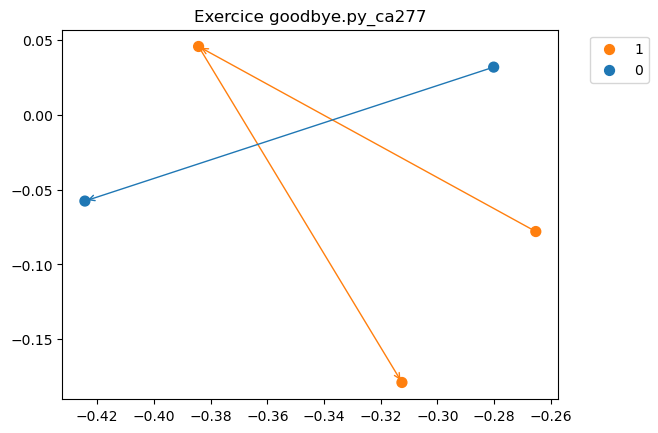

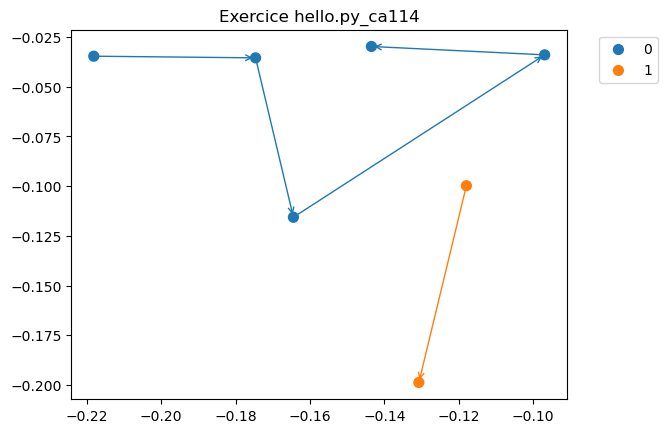

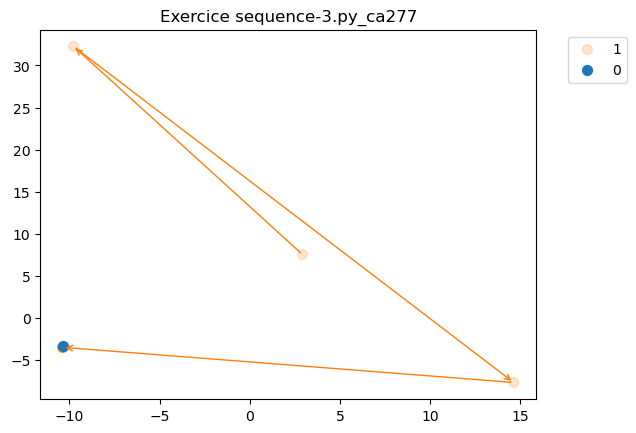

In [746]:
plot_trajectory(data_visualisation, labels_emb)

# Clustering on cos² and levenshtein

In [747]:
# Load data trajectories

with open('Datasets/Trajectories/trajectory_lev_dublin.pkl', 'rb') as fichier:
    trajec_lev = pickle.load(fichier)
with open('Datasets/Trajectories/trajectory_cos_dublin.pkl', 'rb') as fichier:
    trajec_cos = pickle.load(fichier)
with open('Datasets/Trajectories/trajectory_date_dublin.pkl', 'rb') as fichier:
    trajec_date = pickle.load(fichier)

In [748]:
# Since we are taking a percentage of the data, we adapt the trajec_method data to match our reduced dataset
attempts_ex_student = {}
for attempts in dublin_data_sampled:
    exercise = attempts["exercise_name"]
    student = attempts["user"]
    if exercise not in attempts_ex_student:
        attempts_ex_student[exercise] = {}
    if student not in attempts_ex_student[exercise]:
         attempts_ex_student[exercise][student] = 0
    attempts_ex_student[exercise][student] += 1


for exercise in tqdm(attempts_ex_student):
    for student in (attempts_ex_student[exercise]):
        if len(trajec_lev[exercise][student]) > attempts_ex_student[exercise][student]:
            while len(trajec_lev[exercise][student]) > attempts_ex_student[exercise][student]:
                index = range(len(trajec_lev[exercise][student])-1)
                index_random = random.choice(index)
                trajec_lev[exercise][student].pop(index_random)
                trajec_cos[exercise][student].pop(index_random)
                trajec_date[exercise][student].pop(index_random)

  0%|          | 0/92 [00:00<?, ?it/s]

In [749]:
# Since we are taking a percentage of the data, we adapt the trajec_method data to match our reduced dataset

copy_trajec = {}
for exercise in trajec_lev:
    copy_trajec[exercise] = {}
    for student in trajec_lev[exercise]:
        copy_trajec[exercise][student] = 0

In [750]:
# Since we are taking a percentage of the data, we adapt the trajec_method data to match our reduced dataset

for exercise in copy_trajec:
    if exercise not in attempts_ex_student:
        del trajec_lev[exercise]
        del trajec_cos[exercise]
        del trajec_date[exercise]

In [751]:
# Since we are taking a percentage of the data, we adapt the trajec_method data to match our reduced dataset

for exercise in attempts_ex_student:
    if len(attempts_ex_student[exercise]) < len(trajec_lev[exercise]):
        for student in copy_trajec[exercise]:
            if student not in attempts_ex_student[exercise]:
                del trajec_lev[exercise][student]
                del trajec_cos[exercise][student]
                del trajec_date[exercise][student]

In [752]:
def compute_cluster(trajec, trajec_date):
    """
    Give the labels from the clustering for each exercise
    """
    diff_date = diff_date_(trajec_date)
    repartition_date = repartition_date_(diff_date)
    padded_trajectory = padd_trajectories(diff_date, repartition_date, trajec)
    labels_ = get_labels(padded_trajectory)
    return labels_

In [753]:
label_compute = True # Put at True if you want to compute the labels

if label_compute:
    start_time = time.time()
    label_lev = compute_cluster(trajec_lev, trajec_date) 
    with open(f'Datasets/labels_lev_dublin_{percentage}.pkl', 'wb') as f:
        pickle.dump(labels_lev, f)
    end_time = time.time()
    time_lev = end_time - start_time
else:
    # Open labels that already exists
    with open(f'Datasets/labels/labels_lev_dublin_{percentage}.pkl', 'rb') as f:
        label_lev = pickle.load(f)  

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

NameError: name 'labels_lev' is not defined

In [754]:
label_compute = True # Put at True if you want to compute the labels

if label_compute:
    start_time = time.time()
    label_cos = compute_cluster(trajec_cos, trajec_date) 
    with open(f'Datasets/labels_cos_dublin_{percentage}.pkl', 'wb') as f:
        pickle.dump(labels_cos, f)
    end_time = time.time()
    time_cos = end_time - start_time
else:
    # Open labels that already exists
    with open(f'Datasets/labels/labels_cos_dublin_{percentage}.pkl', 'rb') as f:
        label_cos = pickle.load(f)  

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

NameError: name 'labels_cos' is not defined

# Plot clustering trajectory cos²

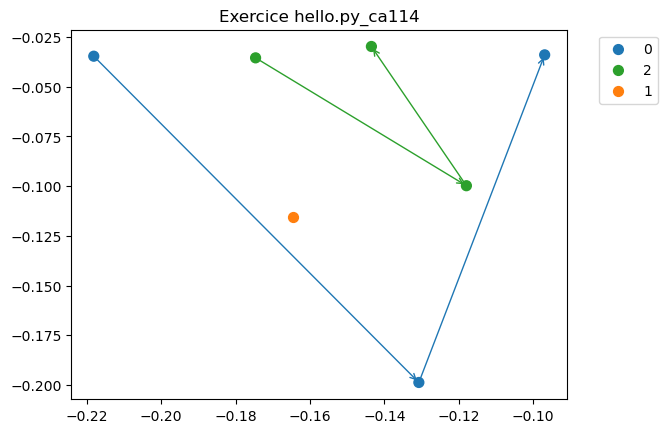

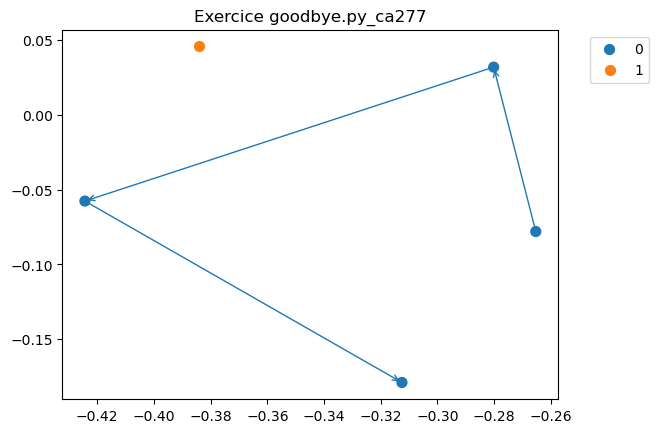

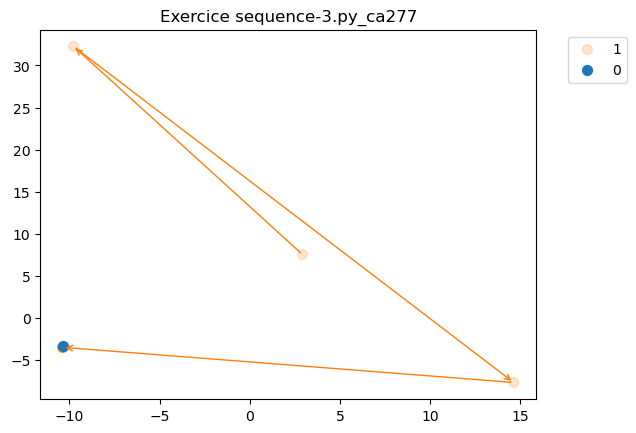

In [755]:
plot_trajectory(data_visualisation, label_cos)

# Plot clustering trajectory lev

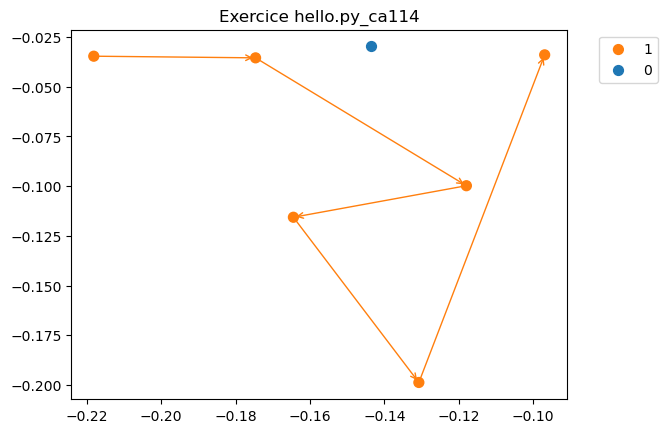

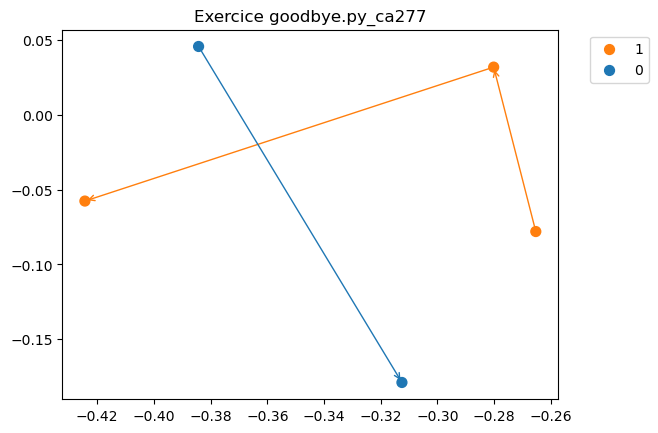

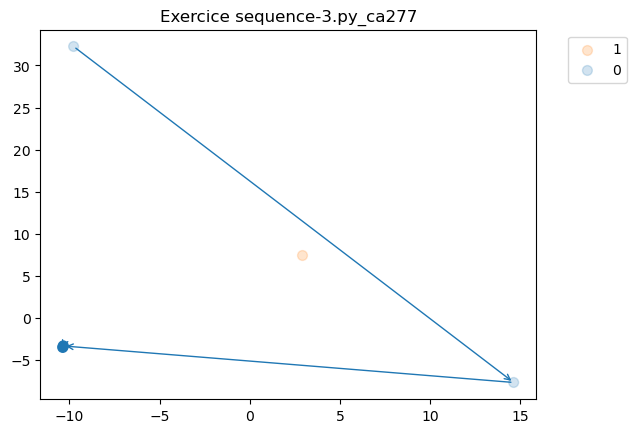

In [756]:
plot_trajectory(data_visualisation, label_lev)

# Comparaison between clustering

In this section, we will compare the quality of the clustering using some metric such as the silouhette, Calinski and Davies-Bouldin score. We will compute our version of thoses metric using the matrix distance to calculate the score for the embedding methode.

## Silouhette score

In [757]:
def distance_matrix(A, B):
    """
    Return the distance between two matrix"
    """
    return np.linalg.norm(A - B, 'fro')

def count_array(array, n):
    """
    Count the number of times that n is in array
    """
    return list(array).count(n)


def list_emb_to_array(row):
    "Reshape 3d array to 2d"
    array = np.array(row)
    a,b,c = array.shape
    array = array.reshape(b,c)
    return array    

We compute the silouhette methode using the algorithme we find in wikipedia using the matrix distance instead of classic distance. https://en.wikipedia.org/wiki/Silhouette_(clustering)

In [758]:
def a_silh(i, labels, data):
    k = labels[i]
    num_in_clus = count_array(labels, k)
    if num_in_clus > 1:
        num_trajec = len(data)
        sum_distance = 0
        array_i = list_emb_to_array(data[i:i+1])
        for j in range(0,num_trajec):
            if i != j and labels[j] == k:
                array_j = list_emb_to_array(data[j:j+1])
                sum_distance += distance_matrix(array_i,array_j)
        a = 1/(num_in_clus-1) * sum_distance
    else:
        a = 0
    return a

def b_silh(i, labels, data):
    list_b_l = []
    k = labels[i]
    num_trajec = len(data)
    array_i = list_emb_to_array(data[i:i+1])
    for q in labels:
        if q!=k:
            num_in_clus_q = count_array(labels, q)
            sum_dis = 0
            for j in range(0,num_trajec):
                if labels[j] == q:
                    array_j = list_emb_to_array(data[j:j+1])
                    sum_dis += distance_matrix(array_i, array_j)
            b_l = 1/num_in_clus_q * sum_dis
            list_b_l.append(b_l)
    return min(list_b_l)

In [759]:
def s_sil(b_sil,a_sil):
    return (b_sil-a_sil)/max(a_sil,b_sil)

In [760]:
def S_sil(K,labels, data):
    sum_S = 0
    num_trajec = len(data)
    for k in range(K):
        num_in_clus = count_array(labels, k)
        if num_in_clus == 0:
            print(labels,k, K)
        sum_silh = 0
        for i in range(num_trajec):
            if labels[i] == k:
                b, a = b_silh(i, labels, data), a_silh(i, labels, data)
                s = s_sil(b,a)
                sum_silh += s
        sum_S += 1/num_in_clus * sum_silh
    S = 1/K * sum_S
    return S

In [761]:
def best_k_silh(data):
    silhouette_scores = []
    max_clus = len(data) - 1
    for K in range(2,max_clus):
        model_emb = TimeSeriesKMeans(n_clusters=K, metric="dtw", max_iter=10)
        labels_emb = model_emb.fit_predict(data)
        silh_score_perso = S_sil(K, labels_emb, data_exo)
        silhouette_scores.append(silh_score_perso)
    return np.argmax(silhouette_scores)

## Calinski

We input the Calinski methode. https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index

In [762]:
def centroid_data_(labels, padded_trajec):
    centroid_data = {}
    for exo in labels:
        centroid_data[exo] = {}
        list_label = labels[exo]
        trajectories = padded_trajec[exo]
        list_trajec = list(trajectories.keys())
        for i, k in enumerate(list_label):
            if k not in centroid_data[exo]:
                centroid_data[exo][k] = []
            trajec = list_trajec[i] 
            centroid_data[exo][k].append(trajectories[trajec])
            
    centroid = {}
    for exo in centroid_data:
        centroid[exo] = {}
        for k in centroid_data[exo]:
            centroid[exo][k] = np.mean(centroid_data[exo][k], axis = 0)
            
                  
            
    l_centroid = {}
    for exo in centroid_data:
        l_centroid[exo] = []
        for k in centroid_data[exo]:
            l_centroid[exo].append(centroid[exo][k])
    centroid_global = {}
    for exo in l_centroid:
        centroid_global[exo] = np.mean(l_centroid[exo], axis = 0)
        
        
        
    return centroid_data, centroid, centroid_global

In [763]:
def BCSS_(dict_label_emb,dict_padded_trajec, dict_centroid, centroid_global):
    BCSS_exo = {}
    for exo in dict_label_emb:
        BCSS_exo[exo] = 0
        K = len(set(dict_label_emb[exo]))
        ni = len(dict_padded_trajec[exo])
        centroid_globale = centroid_global[exo]
        for label in set(dict_label_emb[exo]):
            centroid = dict_centroid[exo][label]
            dis_centr = distance_matrix(centroid,centroid_globale) ** 2
            BCSS_exo[exo] += ni * dis_centr
    return BCSS_exo

In [764]:
def WCSS_(dict_label_emb, dict_centroid_data, centroids):
    WCSS_exo = {}
    for exo in dict_label_emb:
        WCSS_exo[exo] = 0
        for label in set(dict_label_emb[exo]):
            centroid = centroids[exo][label]
            X = dict_centroid_data[exo][label]
            for x in X:
                dis_centr = distance_matrix(centroid,x) ** 2
                WCSS_exo[exo] += dis_centr
    return WCSS_exo

In [765]:
def CH_(BCSS, WCSS, dict_padded_trajec, dict_label_emb):
    CH = {}
    for exo in BCSS:
        BCSS_exo = BCSS[exo]
        WCSS_exo = WCSS[exo]
        k = len(set(dict_label_emb[exo]))
        n = len(dict_padded_trajec[exo])
        numerator = BCSS_exo/(k-1)
        denominator = WCSS_exo/(n-k)
        if n-k <0:
            print("yes")
        CH[exo] = numerator/denominator
    return CH

In [766]:
trajec_emb, trajec_emb_date = trajectory_construction_embedding(dublin_data_sampled, embedding_data_sampled)
diff_date = diff_date_(trajec_emb_date)
repartition_date = repartition_date_(diff_date)
padded_trajectory = padd_trajectories(diff_date, repartition_date, trajec_emb)

In [767]:
centroid_data, centroid, centroid_global = centroid_data_(labels_emb, padded_trajectory)

In [768]:
BCSS = BCSS_(labels_emb, padded_trajectory, centroid, centroid_global)
WCSS =  WCSS_(labels_emb, centroid_data, centroid)
CH = CH_(BCSS, WCSS, padded_trajectory, labels_emb)

In [769]:
# For embedding
score_emb = {}
for exo in tqdm(labels_emb):
    X = np.array(list(padded_trajectory[exo].values()))
    y = labels_emb[exo]
    K = len(set(y))
    silhouette_avg = S_sil(K,y,X)
    score_emb[exo] = silhouette_avg


  0%|          | 0/88 [00:00<?, ?it/s]

# Davies-Bouldin

Same way, we compute the DB methode. https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index

In [783]:
def Si_(dict_padded_trajec, dict_centroid, dict_label_emb):
    Si_dict = {}
    for exo in dict_label_emb:
        labels = dict_label_emb[exo]
        centroids = dict_centroid[exo]
        trajecs = dict_padded_trajec[exo]
        list_stu = list(trajecs.keys())
        Si_dict[exo] = {}
        for i, label in enumerate(labels):
            if label not in Si_dict[exo]:
                Si_dict[exo][label] = 0
            student = list_stu[i]
            Xj = trajecs[student]
            centroid = centroids[label]
            dis = distance_matrix(Xj,centroid)
            Si_dict[exo][label] += dis
            
    for exo in Si_dict:
        for label in Si_dict[exo]:
            T_i = count_array(dict_label_emb[exo],label)
            Si_dict[exo][label] /= T_i
    return Si_dict

In [784]:
def M_(dict_centroid):
    M_dict = {}
    for exo in dict_centroid:
        M_dict[exo] = {}
        list_label = list(dict_centroid[exo].keys())
        for label_i in list_label:
            M_dict[exo][label_i] = {}
            centroid_i = dict_centroid[exo][label_i]
            for label_j in list_label:
                if label_i != label_j:
                    centroid_j = dict_centroid[exo][label_j]
                    dis = distance_matrix(centroid_i, centroid_j)
                    M_dict[exo][label_i][label_j] = dis
    return M_dict

In [785]:
def R_(M,S):
    R_dict = {}
    for exo in S:
        R_dict[exo] = {}
        for label_i in S[exo]:
            Si = S[exo][label_i]
            R_dict[exo][label_i] = []
            for label_j in S[exo]:
                Sj = S[exo][label_j]
                if label_i != label_j:
                    Mij = M[exo][label_i][label_j]
                    Rij = (Si+Sj)/Mij
                    R_dict[exo][label_i].append(Rij)
    return R_dict

In [786]:
def D_(R):
    D_dict = {}
    for exo in R:
        D_dict[exo] = {}
        for label in R[exo]:
            D_i = max(R[exo][label])
            D_dict[exo][label] = D_i
    return D_dict

In [787]:
def DB_(D):
    DB_dict = {}
    for exo in D:
        DB_dict[exo] = 0
        for label in D[exo]:
            DB_dict[exo]+= D[exo][label]
        DB_dict[exo]/= len(D[exo])
    return DB_dict

In [788]:
M, S =  M_(centroid), Si_(padded_trajectory, centroid, labels_emb)
R = R_(M,S)
D = D_(R)
DB = DB_(D)

## Score for the embedding methode

In [789]:
embedding_methode = {"Silouhette_score" : sum(score_emb.values()),"Davies_bouldin" : sum(DB.values()), "Calisnki" : sum(CH.values()) }


## Score of cos² methode

In [790]:
# Get padded_trajectory for cos² methode
diff_date = diff_date_(trajec_date)
repartition_date = repartition_date_(diff_date)
padded_trajectory_cos2 = padd_trajectories(diff_date, repartition_date, trajec_cos)

In [791]:
cos_methode = {"Silouhette_score" : 0, 'Davies_bouldin' : 0, "Calisnki" : 0}
for exo in tqdm(label_cos):
    X = np.array(list(padded_trajectory_cos2[exo].values()))
    y = label_cos[exo]

    silhouette_avg = silhouette_score(X, y)
    calinski_harabasz_avg = calinski_harabasz_score(X, y)
    davies_bouldin_avg = davies_bouldin_score(X, y)
    
    
    cos_methode["Silouhette_score"] += silhouette_avg
    cos_methode["Davies_bouldin"] += davies_bouldin_avg
    cos_methode["Calisnki"] += calinski_harabasz_avg

  0%|          | 0/88 [00:00<?, ?it/s]

## Score of lev methode

In [792]:
# Get padded_trajectory for cos² methode
diff_date = diff_date_(trajec_date)
repartition_date = repartition_date_(diff_date)
padded_trajectory_lev = padd_trajectories(diff_date, repartition_date, trajec_lev)

In [793]:
lev_methode = {"Silouhette_score" : 0, 'Davies_bouldin' : 0, "Calisnki" : 0}
for exo in tqdm(label_lev):
    X = np.array(list(padded_trajectory_lev[exo].values()))
    y = label_lev[exo]

    silhouette_avg = silhouette_score(X, y)
    calinski_harabasz_avg = calinski_harabasz_score(X, y)
    davies_bouldin_avg = davies_bouldin_score(X, y)
    
    
    lev_methode["Silouhette_score"] += silhouette_avg
    lev_methode["Davies_bouldin"] += davies_bouldin_avg
    lev_methode["Calisnki"] += calinski_harabasz_avg

  0%|          | 0/88 [00:00<?, ?it/s]

In [794]:
# m for min and M for max
m, M = 0,0
for exercise in padded_trajectory:
    for student in padded_trajectory[exercise]:
        for i in range(len(padded_trajectory[exercise][student])):
            m = min(m,min(padded_trajectory[exercise][student][i]))
            M = max(M,max(padded_trajectory[exercise][student][i]))

In [795]:
df_score = pd.DataFrame([embedding_methode, lev_methode, cos_methode], index=['embbeding','levenshtein', 'cos²'])
df_score

,Silouhette_score,Davies_bouldin,Calisnki
embbeding,57.026649,57.084319,128264.667100
levenshtein,61.154457,32.405640,28129.684990
cos²,64.094358,32.730093,23654.338752
